Evaluation of the Fashion-MINST Database Using Ensemble-based XGBoost and Neural Network-based TensorFlow Models

Author: Prabode Weebadde

Note:

To install GPU support on Macbook Pro M2 Max chip follow the excellent tutorial by J. Hanson.
https://www.youtube.com/watch?v=5DgWvU0p2bk

Credits

SUBHAYAN SAMANTA, https://www.kaggle.com/code/subhayan2018/exploring-xgboost-with-fashion-mnist


In [ ]:
# make sure you have the imported libraries if not you can uncomment the following lines to install them. 
# After installation comment the lines again.
# !!! pip install pandas
# !!! pip install numpy
# !!! pip install matplotlib
# !!! pip install seaborn
# !!! pip install scikit-learn
# !!! pip install sklearn
# !!! pip install xgboost
# !!! pip install keras
# !!! pip install pandas

In [56]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras as k
from sklearn.metrics import classification_report
sns.set()
import time
%matplotlib inline

In [57]:
# these are helper methods created to load data and get the human readable name for the category
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

def category_name(category_id):
    """Load Fashion-MNIST category name by category id."""
    cats = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}
    return cats[category_id]

def plot_image(img, label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel(label)

In [58]:
x_train, y_train = load_mnist('data/fashion', kind='train')
x_test, y_test = load_mnist('data/fashion', kind='t10k')

In [59]:
print("training images",x_train.shape, type(x_train))
print("training labels",y_train.shape, type(y_train))
print("testing images",x_test.shape, type(x_train))
print("testing labels",y_test.shape, type(y_train))

training images (60000, 784) <class 'numpy.ndarray'>
training labels (60000,) <class 'numpy.ndarray'>
testing images (10000, 784) <class 'numpy.ndarray'>
testing labels (10000,) <class 'numpy.ndarray'>


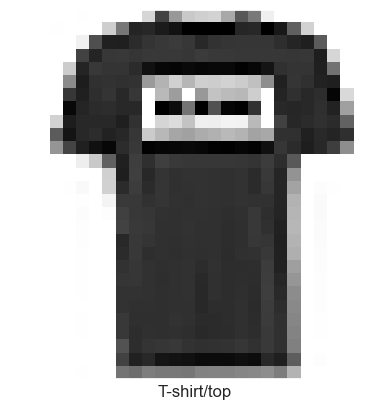

In [60]:
plot_image(x_train[1].reshape((28,28)),category_name(y_train[1]))

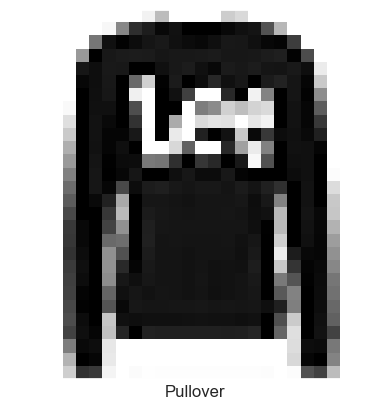

In [61]:
plot_image(x_test[1].reshape((28,28)),category_name(y_test[1]))

In [62]:
# set up xgboost 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [82]:
# training model with best guess hyperparameters
start = time.time()
xgb_clf_one = XGBClassifier(n_estimators=500, n_jobs=-1, learning_rate=0.5, min_child_weight= 1, reg_lambda =20, seed=0)
xgb_clf_one.fit(x_train,y_train)
stop = time.time()
print(xgb_clf_one.get_params)
print(f"Training time: {stop - start}s")

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)>
Training time: 743.6444802284241s


In [83]:
pred = xgb_clf_one.predict(x_test)
print('generating classification report for xgb_clf_one')
print(classification_report(y_test,pred))

generating classification report for xgb_clf_one
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.82      0.85      0.84      1000
           3       0.90      0.92      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.70      0.73      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [66]:
# GridSearchCV model tuning 
# Credits: David Martins
# URL: https://towardsdatascience.com/
#      xgboost-fine-tune-and-optimize-your-model-23d996fab663

from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6],
           'learning_rate': [0.01, 0.05,],
           'n_estimators': [100, 500],
           'colsample_bytree': [0.3, 0.7]}
xgbr = XGBClassifier(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Lowest RMSE:  1.1592813866069502


In [80]:
# training model with GridSearchCV hyperparameters
start = time.time()
xgb_clf_two = XGBClassifier(n_estimators=500, learning_rate=0.05, colsample_bytree=0.7, max_depth=6, seed=0)
xgb_clf_two.fit(x_train,y_train)
stop = time.time()
print(xgb_clf_two.get_params)
print(f"Training time: {stop - start}s")

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)>
Training time: 549.2710139751434s


In [81]:
pred = xgb_clf_two.predict(x_test)
print('generating classification report for xgb_clf_two')
print(classification_report(y_test,pred))

generating classification report for xgb_clf_two
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       1.00      0.97      0.99      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.92      0.91      1000
           4       0.82      0.84      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.73      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [72]:
# training model with best guess hyperparameters 2
start = time.time()
xgb_clf_three = XGBClassifier(n_estimators=500, n_jobs=-1, learning_rate=0.5,colsample_bytree=0.7, max_depth=6, min_child_weight=1, reg_lambda=20, seed=0)
xgb_clf_three.fit(x_train,y_train)
stop = time.time()
print(xgb_clf_three.get_params)
print(f"Training time: {stop - start}s")

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)>
Training time: 528.6568138599396s
test accuracy
0.9059


In [79]:
pred = xgb_clf_three.predict(x_test)
print('generating classification report for xgb_clf_three')
print(classification_report(y_test,pred))

generating classification report for xgb_clf_three
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.70      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [77]:
# training model with best guess hyperparameters 3
start = time.time()
xgb_clf_four = XGBClassifier(n_estimators=500, n_jobs=-1, learning_rate=0.5, seed=0)
xgb_clf_four.fit(x_train,y_train)
stop = time.time()
print(xgb_clf_four.get_params)
print(f"Training time: {stop - start}s")

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)>
Training time: 598.790778875351s


In [78]:
pred = xgb_clf_four.predict(x_test)
print('generating classification report for xgb_clf_four')
print(classification_report(y_test,pred))

generating classification report for xgb_clf_four
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.81      0.84      0.83      1000
           3       0.91      0.92      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.77      0.70      0.73      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.90      0.91      0.90     10000



In [ ]:
# saving the best performed model xgb_clf_three
xgb_clf_three.save_model('saved_model/xgb_model.bin')